# Analysis of Telegram chat exports

### To-Do:
- Define consistent colors for each chat user
- Image analysis (gallery, counts...)
- Switching to Dash

In [11]:
print("Loading the basics!")

import os
import pandas as pd
import json
from datetime import datetime as datetime
import time

## File dialog
import tkinter
from tkinter.filedialog import askopenfilename

## Importing Plotly for visualization
import plotly.express as px
import plotly.graph_objects as go

## Import webbrowser to start the browser
import webbrowser

## Adding a progress bar
from tqdm import tqdm

Loading the basics!


### File Dialog

In [12]:
root = tkinter.Tk()
filename = askopenfilename(filetypes=[("Telegram JSON-files",".json")])
print("Let's get started!")
root.destroy()

Let's get started!


In [13]:
## Duration Analysis
startTime = time.time()

### Variables

In [14]:
format = "%Y-%m-%dT%H:%M:%S"

### Functions

In [25]:
# stringify, used to extract the text type (e.g. link) from a list
def stringify(text_list):
    out = ""
    string_type = ""
    for item in text_list:
        if (type(item)) == str:
            out = out + item
        elif (type(item)) == dict:
            out = out + item["text"]
            string_type = item["type"]
        else:
            pass
    return [string_type,out]

def cleanup(string):
    string = string.replace(",","").replace(".","").replace("!","").replace("?","").replace("-","").replace("(","").replace(")","")
    # adding smiley recognition!
    return string

def create_dict(message_list):
    for word in message_list:
        word = cleanup(word)
        if word.lower() in all_words.keys():
            all_words[word.lower()] = all_words[word.lower()]+1
        else:
            all_words[word.lower()] = 1

In [26]:
# Opening JSON file
f = open(filename, encoding='utf-8')
  
# returns JSON object as 
# a dictionary
data = json.load(f)

# Closing file
f.close()

### Cleaning the data

In [27]:
df = pd.DataFrame(columns=['date', "type", 'name', 'message'])

# Optimized analysis

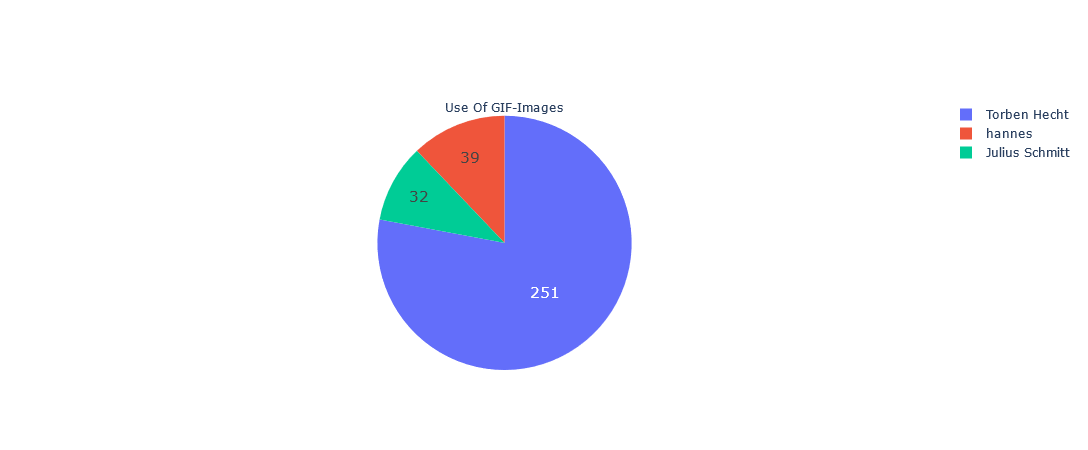

In [28]:
messages = data["messages"]
df_msg = pd.DataFrame(messages)
df_gif = pd.DataFrame(df_msg[df_msg["via_bot"] == "@gif"].groupby("from").count()).sort_values("id",ascending=False).filter(items = ["id"])

labels = df_gif.index.to_list()
values = df_gif["id"].to_list()
gif_count_pie = go.Figure(data=[go.Pie(labels=labels, 
                             values=values, 
                            )])

gif_count_pie.update_traces(hoverinfo='label+value+percent', 
                  textfont_size=15,
                  textinfo='value',
                  title="Use Of GIF-Images",
                  #insidetextorientation='tangential',
                  #marker=dict(colors=colors)
                 )

### Saving the df for later usage

In [29]:
print("Exporting a backup of the analysed file!")
df.to_csv("dataframe.csv")

Exporting a backup of the analysed file!


## Linechart: Messages Per Hour Of The Day
### Analysis of the message per hours of the day

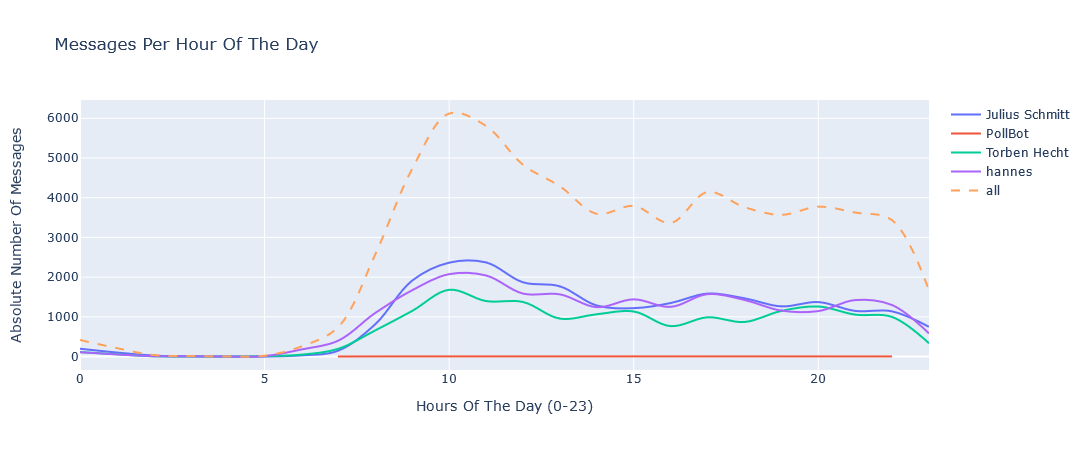

In [30]:
# convert date to datetime
df_msg.date = pd.to_datetime(df_msg.date)

df_msg["hour"] = df_msg.date.dt.hour

df_hours = pd.DataFrame(df_msg.groupby(by=['hour',"from"]).agg('count')["text"]).unstack()

hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

mes_by_hour = go.Figure()
for user in df_hours.columns:
    mes_by_hour.add_trace(go.Scatter(x=hours, y=df_hours.text[user[1]],
                        mode='lines',
                        name=user[1],
                        line_shape='spline',
                        connectgaps=True))

mes_by_hour.add_trace(go.Scatter(x=hours, y=df_hours.sum(axis=1),
                        mode='lines',
                        name="all",
                        line_shape='spline',
                        line=dict(dash='dash'),
                        connectgaps=True))
    
# Edit the layout
mes_by_hour.update_layout(title='Messages Per Hour Of The Day',
                   xaxis_title='Hours Of The Day (0-23)',
                   yaxis_title='Absolute Number Of Messages')

## Linechart: Messages Per Day Of The Week
### Analysis of the message per day of the week

### Plot Messages Per Hour Of The Day

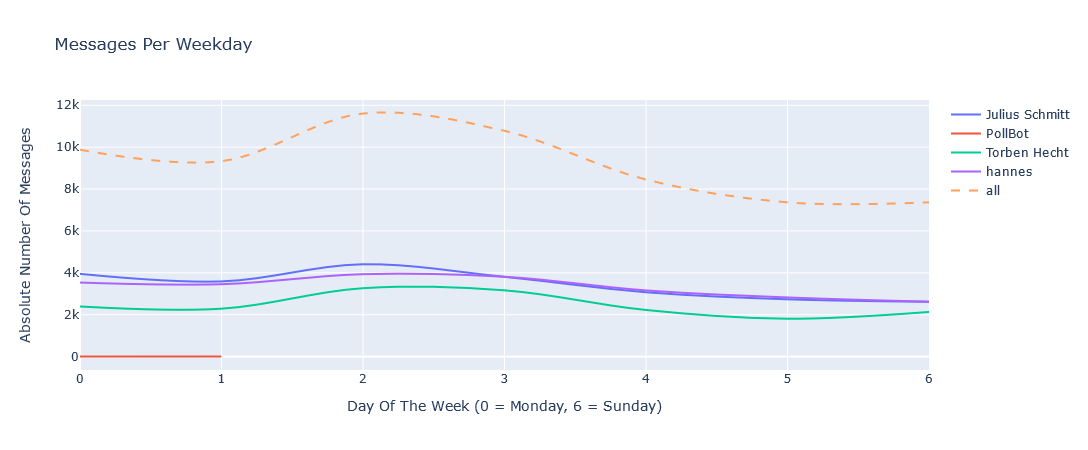

In [31]:
df_msg["weekday"] = df_msg.date.dt.dayofweek
df_days = pd.DataFrame(df_msg.groupby(by=['weekday',"from"]).agg('count')["text"]).unstack()

days = [0,1,2,3,4,5,6]

mes_by_weekday = go.Figure()
for user in df_days.columns:
    mes_by_weekday.add_trace(go.Scatter(x=days, y=df_days.text[user[1]],
                        mode='lines',
                        name=user[1],
                        line_shape='spline',
                        connectgaps=True))

mes_by_weekday.add_trace(go.Scatter(x=days, y=df_days.sum(axis=1),
                        mode='lines',
                        name="all",
                        line_shape='spline',
                        line=dict(dash='dash'),
                        connectgaps=True))
    
# Edit the layout
mes_by_weekday.update_layout(title='Messages Per Weekday',
                   xaxis_title='Day Of The Week (0 = Monday, 6 = Sunday)',
                   yaxis_title='Absolute Number Of Messages')



#print("Analysed the messages by weekday!")

# Messages Per X

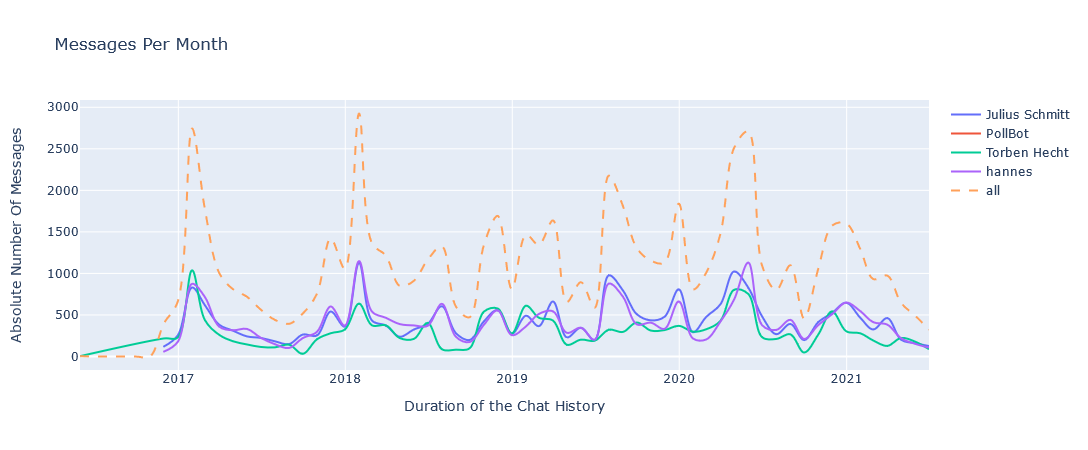

In [32]:
df_mes_by_date = df_msg.groupby(by=[pd.Grouper(key='date',freq='M'),"from"]).count().filter(items = ["id"]).reset_index().groupby(by="from")
users = list(df_mes_by_date.groups.keys())
df_mes_by_date_all = df_msg.groupby(pd.Grouper(key='date',freq='M')).count().filter(items = ["id"])

mes_by_date = go.Figure()
for user in users:
    mes_by_date.add_trace(go.Scatter(x=df_mes_by_date.get_group(user).date, y=df_mes_by_date.get_group(user).id,
                        mode='lines',
                        name=user,
                        line_shape='spline',
                        connectgaps=True))
    

mes_by_date.add_trace(go.Scatter(x=df_mes_by_date_all.index, y=df_mes_by_date_all.id,
                        mode="lines",
                        name="all",
                        line_shape='spline',
                        line=dict(dash='dash'),
                        connectgaps=True))
    
 
# Edit the layout
mes_by_date.update_layout(title='Messages Per Month',
                   xaxis_title='Duration of the Chat History',
                   yaxis_title='Absolute Number Of Messages')

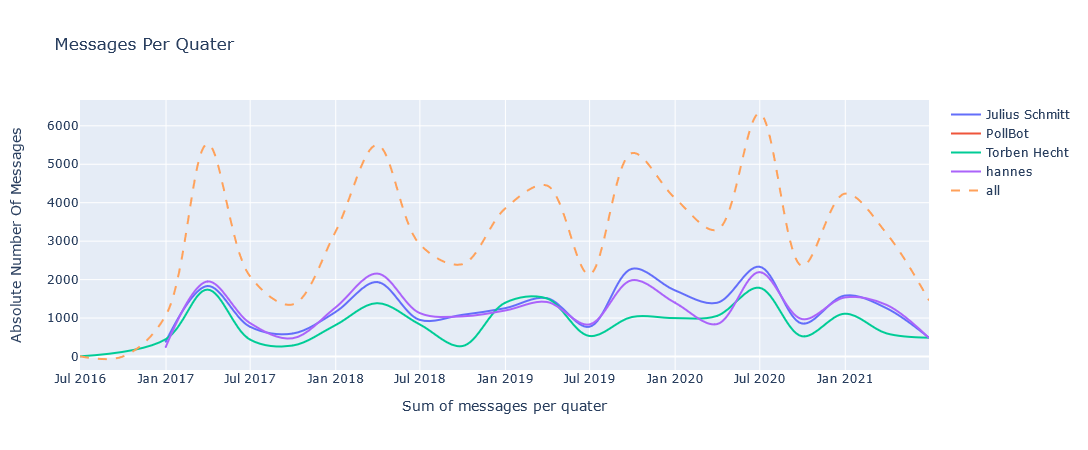

In [33]:
df_mes_by_date = df_msg.groupby(by=[pd.Grouper(key='date',freq='Q'),"from"]).count().filter(items = ["id"]).reset_index().groupby(by="from")
users = list(df_mes_by_date.groups.keys())
df_mes_by_date_all = df_msg.groupby(pd.Grouper(key='date',freq='Q')).count().filter(items = ["id"])

mes_by_quater = go.Figure()
for user in users:
    mes_by_quater.add_trace(go.Scatter(x=df_mes_by_date.get_group(user).date, y=df_mes_by_date.get_group(user).id,
                        mode='lines',
                        name=user,
                        line_shape='spline',
                        connectgaps=True))
    
mes_by_quater.add_trace(go.Scatter(x=df_mes_by_date_all.index, y=df_mes_by_date_all.id,
                        mode="lines",
                        name="all",
                        line_shape='spline',
                        line=dict(dash='dash'),
                        connectgaps=True))
 
# Edit the layout
mes_by_quater.update_layout(title='Messages Per Quater',
                   xaxis_title='Sum of messages per quater',
                   yaxis_title='Absolute Number Of Messages')

## Histogram: Use Of Individual Words

### To-Do:
- Smiley detection
- fix bug with ""
- count all name-pings
- Under Plot The Top 50, show count by user (stacked histogram). Needs a redo of the dataframe

### Plot The Top 50

## Linechart: Analysis of Message Length

### Plot Message Length Over Time

### PieChart: Sum Of All Characters By User

## Linechart: Analysis of Message Count

### Print the top

### Plot Message Count

### PieChart: Total Count of Messages

# All Graphs

In [34]:
html_filename = os.getcwd()+"\\telegram_analysis.html"

with open(html_filename, 'w') as f:
    f.write(mes_by_hour.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(mes_by_weekday.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(mes_by_date.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(gif_count_pie.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(mes_by_quater.to_html(full_html=False, include_plotlyjs='cdn'))
    
webbrowser.open('file://' + os.path.realpath(html_filename)) 

True

In [ ]:
## Finished the script
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

In [ ]:
print("If the browser doesn't open automatically, you can find the HTML-file here:\n",html_filename)